## 1. Import necessary libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
import tensorflow as tf
from sklearn.model_selection import train_test_split,KFold
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

 ## 2. Load and Preprocessing the Dataset

In [2]:
data_dir = "C:/Users/abdel/Desktop/AI PROJECT/lung_cancer_dataset"
categories = os.listdir(data_dir)
print("Categories:", categories)

Categories: ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']


# 3.Prepare dataset arrays

In [3]:
images = []
labels = []

for category in categories:
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=(224, 224), color_mode='grayscale')
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(categories.index(category))

images = np.array(images)
labels = to_categorical(np.array(labels), num_classes=len(categories))

# 4. Split the data into training and testing sets


In [4]:
# Step 1: Split into training + validation and testing sets
train_val_X, test_X, train_val_y, test_y = train_test_split(images, labels, test_size=0.2, random_state=42)

# Step 2: Split training + validation set into training and validation sets (10% of the original dataset)
train_X, val_X, train_y, val_y = train_test_split(train_val_X, train_val_y, test_size=0.1, random_state=42)

# Display the sizes of each dataset
print("Training set size:", train_X.shape[0])
print("Validation set size:", val_X.shape[0])
print("Testing set size:", test_X.shape[0])


Training set size: 10800
Validation set size: 1200
Testing set size: 3000


## 5. Build the CNN Model

In [5]:
def create_model(input_shape=(224, 224, 1), num_classes=len(categories)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
        tf.keras.layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),  
        tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),                      
        tf.keras.layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'),  
        tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),                      
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),  
        tf.keras.layers.Dropout(0.4),                  
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


## 6. Train the model

In [6]:
# Number of folds for cross-validation
n_folds = 2
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Store metrics for each fold
fold_accuracies = []
fold_losses = []

fold = 1
for train_index, val_index in kf.split(images):
    print(f"Training fold {fold}/{n_folds}...")
    
    # Split the data into training and validation sets for this fold
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]
    
    # Create a new instance of the model
    model = create_model(input_shape=(224, 224, 1), num_classes=len(categories))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Callbacks
    checkpoint_cb = ModelCheckpoint(f"best_model_fold{fold}.keras", save_best_only=True)
    early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)
    
    # Train the model for this fold
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=15,
        batch_size=64,
        callbacks=[early_stopping_cb],
        verbose=1
    )
    
    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold} - Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")
    
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)
    
    fold += 1

# Calculate and display the average metrics across folds
average_accuracy = np.mean(fold_accuracies)
average_loss = np.mean(fold_losses)
print(f"\nAverage Accuracy: {average_accuracy:.4f}")
print(f"Average Loss: {average_loss:.4f}")

model.save("lung_cancer_model.h5")
print("Model saved as 'lung_cancer_model.h5'")


Training fold 1/2...


C:\Users\abdel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1091s 9s/step - accuracy: 0.3519 - loss: 1.0991 - val_accuracy: 0.3365 - val_loss: 1.0988
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1150s 10s/step - accuracy: 0.3436 - loss: 1.0960 - val_accuracy: 0.3288 - val_loss: 1.0989
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1239s 11s/step - accuracy: 0.3391 - loss: 1.0982 - val_accuracy: 0.3347 - val_loss: 1.2829
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1098s 9s/step - accuracy: 0.3239 - loss: 1.1163 - val_accuracy: 0.3347 - val_loss: 1.0990
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 799s 7s/step - accuracy: 0.3272 - loss: 1.0991 - val_accuracy: 0.3288 - val_loss: 1.0989
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 741s 6s/step - accuracy: 0.3457 - loss: 1.0984 - val_accuracy: 0.3288 - val_loss: 1.0988
Fold 1 - Validation Accuracy: 0.3365, Validation Loss: 1.0988
Training fold 2/2...
Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 598s 5s/step - accuracy: 0.3539 - loss: 1.0987 - val_accuracy: 0.3379 - val_loss: 1.0975
Epoch 2/

Fold 2 - Validation Accuracy: 0.9503, Validation Loss: 0.1400

Average Accuracy: 0.6434
Average Loss: 0.6194
Model saved as 'lung_cancer_model.h5'


## 7. Plot Training Curves

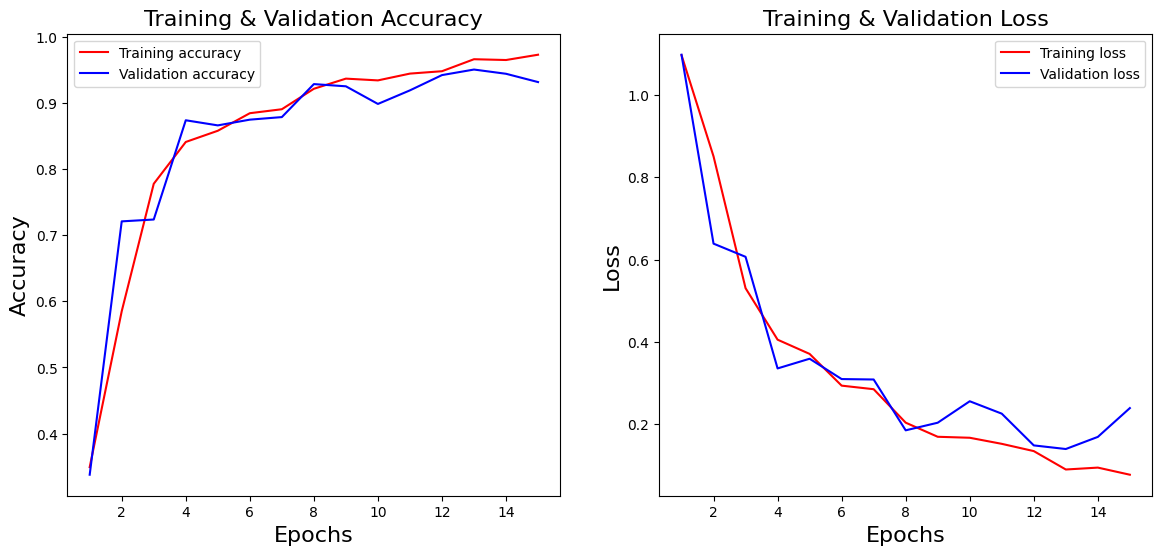

In [7]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Plot training curves
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracy
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot loss
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()


## 8. Evaluate the Model

In [8]:
test_loss, test_acc = model.evaluate(test_X, test_y)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
predictions = model.predict(test_X)



94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 618ms/step - accuracy: 0.9840 - loss: 0.0500
Test loss: 0.04872582107782364
Test accuracy: 0.9836666584014893
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 607ms/step


Confusion Matrix:
 [[998   0  39]
 [  4 966   0]
 [  6   0 987]]


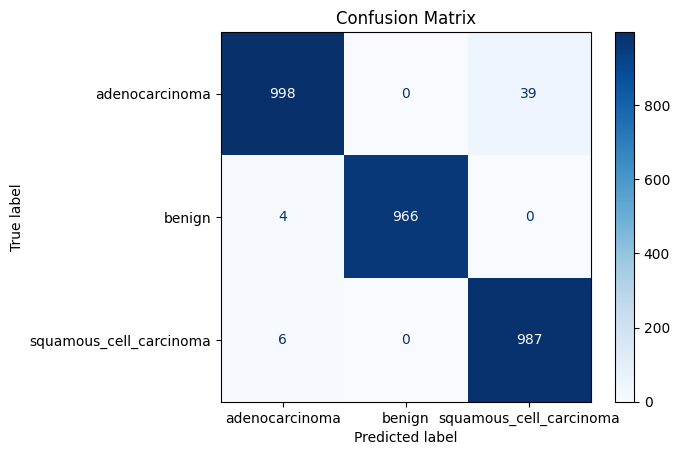

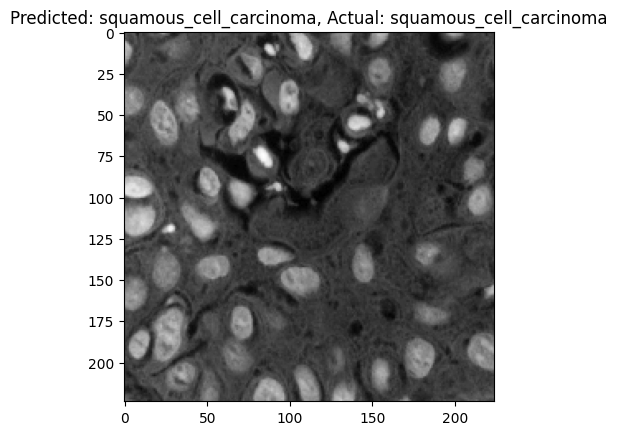

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert predictions and true labels from one-hot encoding to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_y, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Display the first test image and its prediction
plt.imshow(test_X[0].reshape(224, 224), cmap=plt.cm.binary)  # Update resolution if changed
predicted_label = categories[predicted_classes[0]]
actual_label = categories[true_classes[0]]
plt.title(f"Predicted: {predicted_label}, Actual: {actual_label}")
plt.show()
